In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader,DirectoryLoader
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
# from langchain_astradb import AstraDBVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain.schema import Document
from langgraph.graph import START, StateGraph, END
from typing import Literal, List
from typing_extensions import TypedDict
from dotenv import load_dotenv
import os

In [5]:
import langchain

In [11]:
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [12]:
llm = ChatGoogleGenerativeAI(api_key = GOOGLE_API_KEY, model = "gemini-1.5-flash",temperature = 1)
gemini_embedding = GoogleGenerativeAIEmbeddings(google_api_key = GOOGLE_API_KEY, model = "models/embedding-001")

In [13]:
llm.invoke("Hi").content

'Hi there! How can I help you today?\n'

In [ ]:
# i have not runned this aashu you do 
vector_store = AstraDBVectorStore(embedding = gemini_embedding,
                                      api_endpoint = DB_ENDPOINT,
                                      namespace = "constitution",
                                      token = ASTRA_API_KEY,
                                      collection_name = "Law_bot")

retriever = vector_store.as_retriever()

In [14]:
class GraphState(TypedDict):
    question : str
    documents : List[str]
    generation : str    

In [16]:
def route(state):#THIS IS AN EDGE
    question = state["question"]
    print("PP")
    class RouteQuery(BaseModel):
        datasource: Literal["vector-store", "out_of_context"] = Field(..., description = "For a Given User Question Find out whether to route it to vector-store or out_of_context")
    
    system = """You are an expert at routing a user question to a medical knowledge base or out_of_context.
    The knowledge base contains documents related to medical topics. NOTE: if any question relates specifically to medical tests or conditions, use the medical knowledge base.
    Use the knowledge base for questions on these topics. Otherwise, use out_of_context."""


    llm_router = llm.with_structured_output(RouteQuery)

    route_prompt = ChatPromptTemplate.from_messages([("system",system), ("human", "{question}")])
    question_router = route_prompt | llm_router

    response = question_router.invoke({"question" : question})
    print(response)
    if response.datasource == "out_of_context":
        print("==ROUTING TO OUT_OF_CONTEXT===")
        return "out_of_context"
    else:
        print("==ROUTING TO VECTOR STORE===")
        return "vector-store"

In [19]:
def retrieve(state):
    question = state["question"]
    docs = retriever.invoke(question)
    # state["documents"]
    return {"documents" : docs}

In [20]:
def generation(state):
    question = state["question"]
    docs = state["documents"]
    
    # Pull the medical knowledge base prompt
    prompt = hub.pull("medical-chatbot/rag-prompt", api_key=LANGCHAIN_API_KEY) #changed this one also

    # If you have a specific way of formatting the documents, you can re-enable this part
    # def format_docs(docs):
    #     return "\n\n".join(doc.page_content for doc in docs)
    
    # docs = format_docs(docs)
    
    rag_chain = prompt | llm | StrOutputParser()
    
    # Generate response using the medical knowledge base
    generated_text = rag_chain.invoke({"context": docs, "question": question})
    
    return {"documents": docs, "question": question, "generation": generated_text}


In [21]:
def AnswerGrader(state):
    question = state["question"]
    generation = state["generation"]

    class Grade(BaseModel):
        Binary_Score: str = Field(description="Does the answer resolve the query. yes or no")

    structured_llm = llm.with_structured_output(Grade)

    system = """You are a grader assessing whether a medical answer addresses or resolves a medical question.\n
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the medical question correctly."""
    
    
    
    answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ])

    grader_chain = answer_prompt | structured_llm
    response = grader_chain.invoke({"question": question, "generation": generation})

    if response.Binary_Score == "yes":
        return "useful"
    else:
        return "not useful"
    


In [22]:
def Grade_Docs(state):    
    question = state["question"]
    documents = state["documents"]
    class Grade_Docs(BaseModel):
        binary_score : Literal["yes","no"] = Field(...,description = "Documents are relevant to the question, 'yes' or 'no'")

    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages([("system", system),("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),])

    llm_grader = llm.with_structured_output(Grade_Docs)

    retrieval_grader = grade_prompt | llm_grader

    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    # state["documents"] = filtered_docs
    return {"documents": filtered_docs, "question": question}


In [23]:
def transform_query(state):    
    question = state["question"]
    documents = state["documents"]

    system = """You a question re-writer that converts an input question to a better version that is optimized \n
        for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate only one improved question.",
            ),
        ]
    )

    question_rewriter = re_write_prompt | llm | StrOutputParser()
    revised_question = question_rewriter.invoke({"question": question})
    # state["revised_question"] = revised_question
    return {"documents": documents, "question": revised_question}

In [24]:
def decide_to_generate(state):
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [26]:
def out_of_context(State):
    question = State["question"]
    print("The given Question is Out of Context. Please ask relevant questions related to medical or clinical topics.")


In [27]:
workflow = StateGraph(GraphState)

workflow.add_node("out_of_context_node",out_of_context)
workflow.add_node("retrieve_node",retrieve)
workflow.add_node("grade_documents_node",Grade_Docs)
workflow.add_node("generation_node", generation)
workflow.add_node("transform_query_node", transform_query)

workflow.add_conditional_edges(START, route,{
    "vector-store" : "retrieve_node",
    "out_of_context": "out_of_context_node"
})

workflow.add_edge("out_of_context_node", END)
workflow.add_edge("retrieve_node", "grade_documents_node")

workflow.add_conditional_edges("grade_documents_node", decide_to_generate,{
    "transform_query" : "transform_query_node",
    "generate" : "generation_node"
})

workflow.add_edge("transform_query_node", "retrieve_node")

workflow.add_conditional_edges("generation_node", AnswerGrader,{
    "useful" : END,
    "not useful" : "transform_query_node"
})

app = workflow.compile()

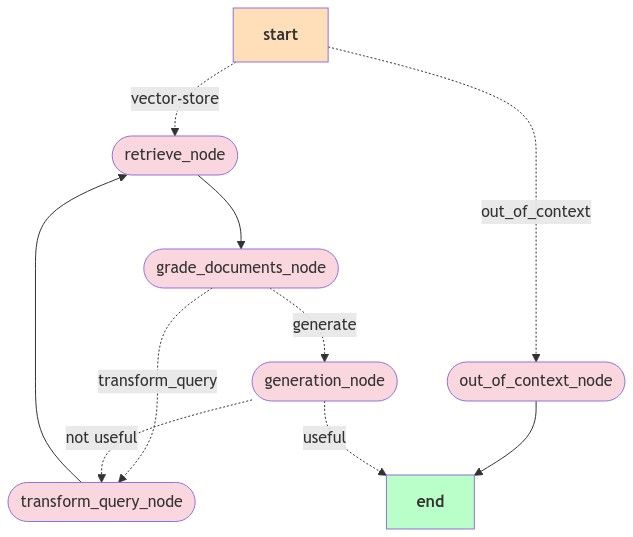

In [28]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass